## Importing Libraries

In [19]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt

## Loading the datasets

In [2]:
# List of file paths for the data from 2005 to 2019

file_paths = [

    '/content/drive/MyDrive/Betting_data/2005.xls',
    '/content/drive/MyDrive/Betting_data/2006.xls',
    '/content/drive/MyDrive/Betting_data/2007.xls',
    '/content/drive/MyDrive/Betting_data/2008.xls',
    '/content/drive/MyDrive/Betting_data/2009.xls',
    '/content/drive/MyDrive/Betting_data/2010.xls',
    '/content/drive/MyDrive/Betting_data/2011.xls',
    '/content/drive/MyDrive/Betting_data/2012.xls',
    '/content/drive/MyDrive/Betting_data/2013.xlsx',
    '/content/drive/MyDrive/Betting_data/2014.xlsx',
    '/content/drive/MyDrive/Betting_data/2015.xlsx',
    '/content/drive/MyDrive/Betting_data/2016.xlsx',
    '/content/drive/MyDrive/Betting_data/2017.xlsx',
    '/content/drive/MyDrive/Betting_data/2018.xlsx',
    '/content/drive/MyDrive/Betting_data/2019.xlsx'
]

# Initializing an empty list to hold DataFrames
data_frames = []

# Loading data into a DataFrame
for file_path in file_paths:
    if os.path.exists(file_path):
        df = pd.read_excel(file_path)
        data_frames.append(df)
    else:
        print(f"File {file_path} not found.")

# Combining all the DataFrames into a single DataFrame
betting_df = pd.concat(data_frames, ignore_index=True)


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
# Verifying the data load

betting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         40390 non-null  int64         
 1   Location    40390 non-null  object        
 2   Tournament  40390 non-null  object        
 3   Date        40390 non-null  datetime64[ns]
 4   Series      40390 non-null  object        
 5   Court       40390 non-null  object        
 6   Surface     40390 non-null  object        
 7   Round       40390 non-null  object        
 8   Best of     40390 non-null  int64         
 9   Winner      40390 non-null  object        
 10  Loser       40390 non-null  object        
 11  WRank       40375 non-null  float64       
 12  LRank       40303 non-null  float64       
 13  WPts        38701 non-null  float64       
 14  LPts        38631 non-null  float64       
 15  W1          40155 non-null  float64       
 16  L1          40157 non-

In [5]:
# Selecting Columns and Data Cleaning

# Converting 'Date' into a datetime object
betting_df["Date"] = pd.to_datetime(betting_df["Date"], errors='coerce')

# Selecting only the relevant columns
columns = [
    "Date",
    "Tournament",
    "Surface",
    "Winner",
    "Loser",
    "WRank",
    "WPts",
    "LRank",
    "LPts",
    "B365W",
    "B365L",
    "PSW",
    "PSL"
]
betting_df = betting_df[columns]

# Converting categorical columns to 'category' data type
categorical_columns = ["Tournament", "Surface"]
betting_df[categorical_columns] = betting_df[categorical_columns].astype("category")

# Handling missing values in 'WRank' and 'LRank'
betting_df["WRank"] = betting_df["WRank"].fillna(100000)
betting_df["LRank"] = betting_df["LRank"].fillna(100000)

# Handling missing values in 'WPts' and 'LPts' by imputing with the median
betting_df["WPts"] = betting_df["WPts"].fillna(betting_df["WPts"].median())
betting_df["LPts"] = betting_df["LPts"].fillna(betting_df["LPts"].median())

# Removing remaining NaN values
betting_df.dropna(inplace=True)

# Creating a higher-ranked player column
betting_df["higher_rank_won"] = betting_df["WRank"] < betting_df["LRank"]

# Calculating the difference in ranking points between the higher and lower-ranked players
betting_df["diff"] = (
    betting_df["WPts"] * betting_df["higher_rank_won"] +
    betting_df["LPts"] * (~betting_df["higher_rank_won"])
) - (
    betting_df["LPts"] * betting_df["higher_rank_won"] +
    betting_df["WPts"] * (~betting_df["higher_rank_won"])
)

# Print the last few rows of the DataFrame to verify the output
print(betting_df.tail())


            Date   Tournament Surface         Winner          Loser  WRank  \
40385 2019-11-15  Masters Cup    Hard      Nadal R.   Tsitsipas S.     1.0   
40386 2019-11-15  Masters Cup    Hard     Zverev A.    Medvedev D.     7.0   
40387 2019-11-16  Masters Cup    Hard  Tsitsipas S.     Federer R.     6.0   
40388 2019-11-16  Masters Cup    Hard      Thiem D.      Zverev A.     5.0   
40389 2019-11-17  Masters Cup    Hard  Tsitsipas S.       Thiem D.     6.0   

         WPts  LRank    LPts  B365W  B365L   PSW   PSL  higher_rank_won  \
40385  9585.0    6.0  4000.0   1.44   2.75  1.39  3.26             True   
40386  2945.0    4.0  5705.0   1.90   1.90  2.14  1.79            False   
40387  4000.0    3.0  6190.0   3.50   1.30  3.75  1.33            False   
40388  5025.0    7.0  2945.0   1.80   2.00  1.84  2.10             True   
40389  4000.0    5.0  5025.0   2.00   1.80  2.00  1.93            False   

         diff  
40385  5585.0  
40386  2760.0  
40387  2190.0  
40388  2080.0  


<ipython-input-5-74acefc4b5c3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_df[categorical_columns] = betting_df[categorical_columns].astype("category")
<ipython-input-5-74acefc4b5c3>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_df["WRank"] = betting_df["WRank"].fillna(100000)
<ipython-input-5-74acefc4b5c3>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [6]:
# Verify the data types
print("Data types:\n", betting_df.dtypes)

Data types:
 Date               datetime64[ns]
Tournament               category
Surface                  category
Winner                     object
Loser                      object
WRank                     float64
WPts                      float64
LRank                     float64
LPts                      float64
B365W                     float64
B365L                     float64
PSW                       float64
PSL                       float64
higher_rank_won              bool
diff                      float64
dtype: object


In [8]:
# Verifying the date range in the dataset
print("Date range in the dataset:")
print(betting_df['Date'].min())
print(betting_df['Date'].max())

# Checking for remaining missing values
print("Missing values after cleaning:")
print(betting_df.isna().sum())

Date range in the dataset:
2005-01-03 00:00:00
2019-11-17 00:00:00
Missing values after cleaning:
Date               0
Tournament         0
Surface            0
Winner             0
Loser              0
WRank              0
WPts               0
LRank              0
LPts               0
B365W              0
B365L              0
PSW                0
PSL                0
higher_rank_won    0
diff               0
dtype: int64


## Data Splitting

In [9]:
# Split the data into training and testing sets based on date
split_date = pd.to_datetime("2019-01-01")
matches_train = betting_df[betting_df["Date"] < split_date]
matches_test = betting_df[betting_df["Date"] >= split_date]

# Prepare the features and target variable
X_train = matches_train[["diff"]]
y_train = matches_train["higher_rank_won"]
X_test = matches_test[["diff"]]
y_test = matches_test["higher_rank_won"]


In [10]:
# Verifying the Split for train

print(X_train.shape, y_train.shape)

(34396, 1) (34396,)


In [11]:
# Verifying the Split for test

print(X_test.shape, y_test.shape)

(2579, 1) (2579,)


## Model Fitting

In [14]:
# Fit the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

## Model Evaluation

In [15]:
# Calculate accuracy and log loss
logistic_accuracy = accuracy_score(y_test, logistic_model.predict(X_test))
logistic_log_loss = log_loss(y_test, y_pred_proba)

# Calculate calibration
logistic_calibration = np.sum(y_pred_proba) / np.sum(y_test)

# Print the results
print("Logistic Model Accuracy:", logistic_accuracy)
print("Logistic Model Log Loss:", logistic_log_loss)
print("Logistic Model Calibration:", logistic_calibration)

# Append results to validation_stats DataFrame
validation_stats = pd.DataFrame({
    "model": ["logistic"],
    "accuracy": [logistic_accuracy],
    "calibration": [logistic_calibration],
    "log_loss": [logistic_log_loss]
})

print(validation_stats)


Logistic Model Accuracy: 0.6145792943001164
Logistic Model Log Loss: 0.6531794960722667
Logistic Model Calibration: 1.0830094170447602
      model  accuracy  calibration  log_loss
0  logistic  0.614579     1.083009  0.653179


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


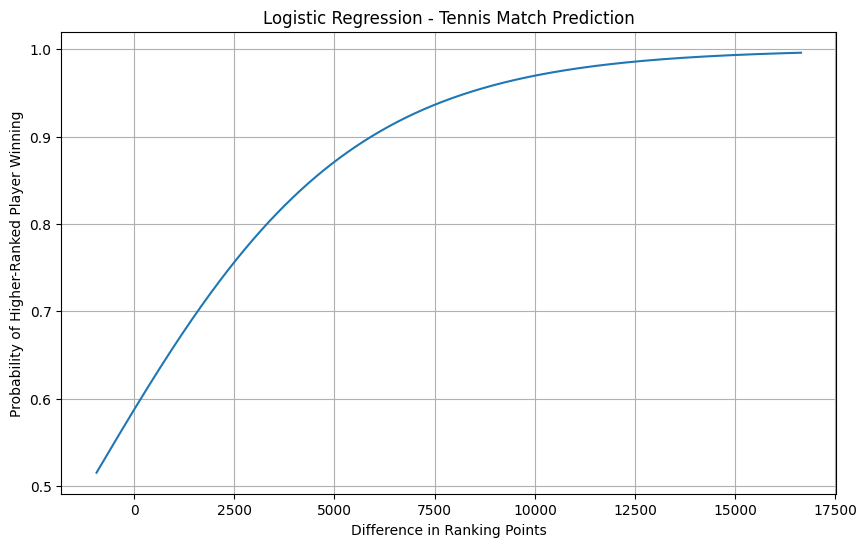

In [18]:
# Generate a range of differences in ranking points
diff_range = np.linspace(X_train["diff"].min(), X_train["diff"].max(), 1000).reshape(-1, 1)

# Predict the probability of the higher-ranked player winning
probabilities = logistic_model.predict_proba(diff_range)[:, 1]

# Plot the probability against the difference in ranking points
plt.figure(figsize=(10, 6))
plt.plot(diff_range, probabilities, label='Probability of Higher-Ranked Player Winning')
plt.title('Logistic Regression - Tennis Match Prediction')
plt.xlabel('Difference in Ranking Points')
plt.ylabel('Probability of Higher-Ranked Player Winning')
plt.grid(True)
plt.show()

# Optimizing Logistic Reg Model using Grid Search

In [22]:
# Defining the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],              # Regularization
    'solver': ['liblinear', 'saga'],      # Solvers
}

# Initializing the logistic regression model
logistic_model = LogisticRegression(max_iter=10000)

# Setting up GridSearchCV
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting the model with the best parameters
grid_search.fit(X_train, y_train)

# Getting the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score}")

# Train the logistic regression model with the best parameters on the full training set
best_logistic_model = grid_search.best_estimator_

# Predict probabilities on the test set
y_pred_proba = best_logistic_model.predict_proba(X_test)[:, 1]


Best Parameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.6767629827212582


In [21]:
# Calculate accuracy and log loss
logistic_accuracy = accuracy_score(y_test, best_logistic_model.predict(X_test))
logistic_log_loss = log_loss(y_test, y_pred_proba)

# Calculate calibration
logistic_calibration = np.sum(y_pred_proba) / np.sum(y_test)

# Print the results
print("Optimized Logistic Model Accuracy:", logistic_accuracy)
print("Optimized Logistic Model Log Loss:", logistic_log_loss)
print("Optimized Logistic Model Calibration:", logistic_calibration)

# Append results to validation_stats DataFrame
validation_stats = pd.DataFrame({
    "model": ["optimized_logistic"],
    "accuracy": [logistic_accuracy],
    "calibration": [logistic_calibration],
    "log_loss": [logistic_log_loss]
})

print(validation_stats)

Optimized Logistic Model Accuracy: 0.6145792943001164
Optimized Logistic Model Log Loss: 0.651181509056977
Optimized Logistic Model Calibration: 1.038517993275239
                model  accuracy  calibration  log_loss
0  optimized_logistic  0.614579     1.038518  0.651182


**As you can see above the accuracy remained the same, however there was slight improvement in Calibration and Log_Loss.**